In [1]:
import numpy as np 
import scipy.io as sio
import matplotlib.pyplot as plt 
import seaborn as sn
import pandas as pd

import torch
import os 

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader,random_split

from sklearn.model_selection import train_test_split

torch.manual_seed(1234)
np.random.seed(1234)

## Instancing on the GPU

In [2]:
device = torch.device("cuda")

## Loading the images

In [5]:
Mean_Images = sio.loadmat("images.mat")["img"] #corresponding to the images mean for all the seven windows
print(np.shape(Mean_Images)) 

Images = sio.loadmat("images_time.mat")["img"] #corresponding to the images mean for all the seven windows
print(np.shape(Images)) 


Label = (sio.loadmat("FeatureMat_timeWin")["features"][:,-1]-1).astype(int)
print(np.shape(Label)) 

Patient_id = sio.loadmat("trials_subNums.mat")['subjectNum'][0]
print(np.shape(Patient_id))

(2670, 3, 32, 32)
(2670, 7, 3, 32, 32)
(2670,)
(2670,)


### Dataloader

In [6]:
class EEGImagesDataset(Dataset):
    """EEGLearn Images Dataset from EEG."""
    
    def __init__(self, label, image):
        self.label = Label
        self.Images = image
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.Images[idx]
        label = self.label[idx]
        sample = (image, label)
        
        return sample

### K-Fold Validation

In [7]:
def kfold(length, n_fold):
    tot_id = np.arange(length)
    np.random.shuffle(tot_id)
    len_fold = int(length/n_fold)
    train_id = []
    test_id = []
    for i in range(n_fold):
        test_id.append(tot_id[i*len_fold:(i+1)*len_fold])
        train_id.append(np.hstack([tot_id[0:i*len_fold],tot_id[(i+1)*len_fold:-1]]))
    return train_id, test_id

# Mean Image

## Basic Model

In [8]:
class BasicCNN(nn.Module):
    '''
    Build the  Mean Basic model performing a classification with CNN 

    param input_image: list of EEG image [batch_size, n_window, n_channel, h, w]
    param kernel: kernel size used for the convolutional layers
    param stride: stride apply during the convolutions
    param padding: padding used during the convolutions
    param max_kernel: kernel used for the maxpooling steps
    param n_classes: number of classes
    return x: output of the last layers after the log softmax
    '''
    def __init__(self, input_image=torch.zeros(1, 3, 32, 32), kernel=(3,3), stride=1, padding=1,max_kernel=(2,2), n_classes=4):
        super(BasicCNN, self).__init__()

        n_window = input_image.shape[1]
        n_channel = input_image.shape[2]

        self.conv1 = nn.Conv2d(3,32,kernel,stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(32,32,kernel,stride=stride, padding=padding)
        self.conv3 = nn.Conv2d(32,32,kernel,stride=stride, padding=padding)
        self.conv4 = nn.Conv2d(32,32,kernel,stride=stride, padding=padding)
        self.pool1 = nn.MaxPool2d(max_kernel)
        self.conv5 = nn.Conv2d(32,64,kernel,stride=stride,padding=padding)
        self.conv6 = nn.Conv2d(64,64,kernel,stride=stride,padding=padding)
        self.conv7 = nn.Conv2d(64,128,kernel,stride=stride,padding=padding)

        self.pool = nn.MaxPool2d((1,1))
        self.drop = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(2048,512)
        self.fc2 = nn.Linear(512,n_classes)
        self.max = nn.LogSoftmax()
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool1(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool1(x)
        x = F.relu(self.conv7(x))
        x = self.pool1(x)
        x = x.reshape(x.shape[0],x.shape[1], -1)
        x = self.pool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.max(x)
        return x

In [10]:
EEG = EEGImagesDataset(label=Label, image=Mean_Images)

lengths = [int(2670*0.8), int(2670*0.2)]
Train, Test = random_split(EEG, lengths)

Trainloader = DataLoader(Train,batch_size=32)
Testloader = DataLoader(Test, batch_size=32)

In [140]:
net = BasicCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0.0
    evaluation = []
    for i, data in enumerate(Trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(torch.float32).cuda())
        _, predicted = torch.max(outputs.cpu().data, 1)
        evaluation.append((predicted==labels).tolist())
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    running_loss = running_loss/(i+1)
    evaluation = [item for sublist in evaluation for item in sublist]
    running_acc = sum(evaluation)/len(evaluation)
    validation_loss, validation_acc = Test_Model(net, Testloader,True)

print('Finished Training')

/home/vdelv/anaconda3/envs/Pytorch_EEG/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Finished Training


In [139]:
res = TrainTest_Model(BasicCNN, Trainloader, Testloader, n_epoch=10)

/home/vdelv/anaconda3/envs/Pytorch_EEG/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[5,  10]	loss: 1.384	Accuracy : 0.277		val-loss: 1.383	val-Accuracy : 0.311
[10,  10]	loss: 1.383	Accuracy : 0.277		val-loss: 1.382	val-Accuracy : 0.311
Finished Training 
 loss: 1.383	Accuracy : 0.277		val-loss: 1.382	val-Accuracy : 0.311


In [111]:
def Test_Model(net, Testloader, is_cuda=True):
    running_loss = 0.0 
    evaluation = []
    for i, data in enumerate(Testloader, 0):
        input_img, labels = data
        optimizer.zero_grad()
        input_img = input_img.to(torch.float32)
        if is_cuda:
            input_img = input_img.cuda()
        outputs = net(input_img)
        _, predicted = torch.max(outputs.cpu().data, 1)
        evaluation.append((predicted==labels).tolist())
        loss = criterion(outputs, labels.cuda())
        running_loss += loss.item()
    running_loss = running_loss/(i+1)
    evaluation = [item for sublist in evaluation for item in sublist]
    running_acc = sum(evaluation)/len(evaluation)
    return running_loss, running_acc

In [138]:
def TrainTest_Model(model, trainloader, testloader, n_epoch=30, opti='SGD', learning_rate=0.0001, is_cuda=True, print_epoch =5):
    if is_cuda:
        net = model().cuda()
    else :
        net = model()
        
    criterion = nn.CrossEntropyLoss()
    
    if opti=='SGD':
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    elif opti =='Adam':
        optimizer = optim.Adam(CNN.parameters(), lr=learning_rate)
    else: 
        print("Optimizer: "+optim+" not implemented.")
    
    for epoch in range(n_epoch):
        running_loss = 0.0
        evaluation = []
        for i, data in enumerate(Trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.to(torch.float32).cuda())
            _, predicted = torch.max(outputs.cpu().data, 1)
            evaluation.append((predicted==labels).tolist())
            loss = criterion(outputs, labels.cuda())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        running_loss = running_loss/(i+1)
        evaluation = [item for sublist in evaluation for item in sublist]
        running_acc = sum(evaluation)/len(evaluation)
        validation_loss, validation_acc = Test_Model(net, Testloader,True)
        
        if epoch%print_epoch==(print_epoch-1):
            print('[%d, %3d]\tloss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
             (epoch+1, n_epoch, running_loss, running_acc, validation_loss, validation_acc))
    
    print('Finished Training \n loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
                 (running_loss, running_acc, validation_loss,validation_acc))
    
    return (running_loss, running_acc, validation_loss,validation_acc)

In [477]:
p = 0
fold_vloss = np.zeros((n_fold,n_patient))
fold_loss = np.zeros((n_fold,n_patient))
fold_vacc = np.zeros((n_fold,n_patient))
fold_acc = np.zeros((n_fold,n_patient))
for patient in np.unique(Patient):
    id_patient = np.arange(len(Mean_Images))[Patient==patient]
    n_fold = 5
    length = len(id_patient)
    
    n_patient = len(np.unique(Patient))
    
    train_id, test_id = kfold(length,n_fold)
    
    for fold in range(n_fold):
        X_train = Mean_Images[id_patient[train_id[fold]]]
        X_test = Mean_Images[id_patient[test_id[fold]]]
        y_train = Label[id_patient[train_id[fold]]]
        y_test = Label[id_patient[test_id[fold]]] 

        print("Begin Training Fold %d/%d\t of Patient %d" % 
             (fold+1,n_fold, patient))

        CNN = BasicCNN().cuda(0)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(CNN.parameters(), lr=0.001, momentum=0.9)

        n_epochs = 50
        for epoch in range(n_epochs):
            running_loss = 0.0
            batchsize = 5
            for i in range(int(len(y_train)/batchsize)):
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = CNN(torch.from_numpy(X_train[i:i+batchsize]).to(torch.float32).cuda())
                loss = criterion(outputs, torch.from_numpy(y_train[i:i+batchsize]).to(torch.long).cuda())
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            #acc
            _, idx = torch.max(CNN(torch.from_numpy(X_train[:]).to(torch.float32).cuda()).data,1)
            acc = (idx == torch.from_numpy(y_train).cuda()).sum().item()/len(y_train)

            #val Loss
            val_outputs = CNN(torch.from_numpy(X_test[:]).to(torch.float32).cuda())
            val_loss = criterion(val_outputs, torch.from_numpy(y_test[:]).to(torch.long).cuda())
            _, idx = torch.max(val_outputs.data,1)
            val_acc = (idx == torch.from_numpy(y_test).cuda()).sum().item()/len(y_test)

            #if epoch%10==0:
            #    print('[%d, %3d] loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
            #     (epoch+1, n_epochs, running_loss/i, float(acc), val_loss, val_acc))
        fold_vloss[fold, p ] = val_loss.item()
        fold_loss[fold, p] = running_loss/i
        fold_vacc[fold, p] = val_acc
        fold_acc[fold, p] = acc
        print('Finish Training Fold %d/%d\t of Patient %d' % 
             (fold+1,n_fold, patient))
    print('loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
                 (np.mean(fold_loss[:,p]), np.mean(fold_acc[:,p]), np.mean(fold_vloss[:,p]),np.mean(fold_vacc[:,p])))
    
    p = p + 1

Begin Training Fold 1/5	 of Patient 1


c:\users\victo\.conda\envs\pytorch_eeg\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Finish Training Fold 1/5	 of Patient 1
Begin Training Fold 2/5	 of Patient 1
Finish Training Fold 2/5	 of Patient 1
Begin Training Fold 3/5	 of Patient 1
Finish Training Fold 3/5	 of Patient 1
Begin Training Fold 4/5	 of Patient 1
Finish Training Fold 4/5	 of Patient 1
Begin Training Fold 5/5	 of Patient 1
Finish Training Fold 5/5	 of Patient 1
loss: 0.854	Accuracy : 0.855		val-loss: 0.956	val-Accuracy : 0.805
Begin Training Fold 1/5	 of Patient 2
Finish Training Fold 1/5	 of Patient 2
Begin Training Fold 2/5	 of Patient 2
Finish Training Fold 2/5	 of Patient 2
Begin Training Fold 3/5	 of Patient 2
Finish Training Fold 3/5	 of Patient 2
Begin Training Fold 4/5	 of Patient 2
Finish Training Fold 4/5	 of Patient 2
Begin Training Fold 5/5	 of Patient 2
Finish Training Fold 5/5	 of Patient 2
loss: 0.824	Accuracy : 0.872		val-loss: 0.897	val-Accuracy : 0.852
Begin Training Fold 1/5	 of Patient 3
Finish Training Fold 1/5	 of Patient 3
Begin Training Fold 2/5	 of Patient 3
Finish Training Fol

### Peresented Results

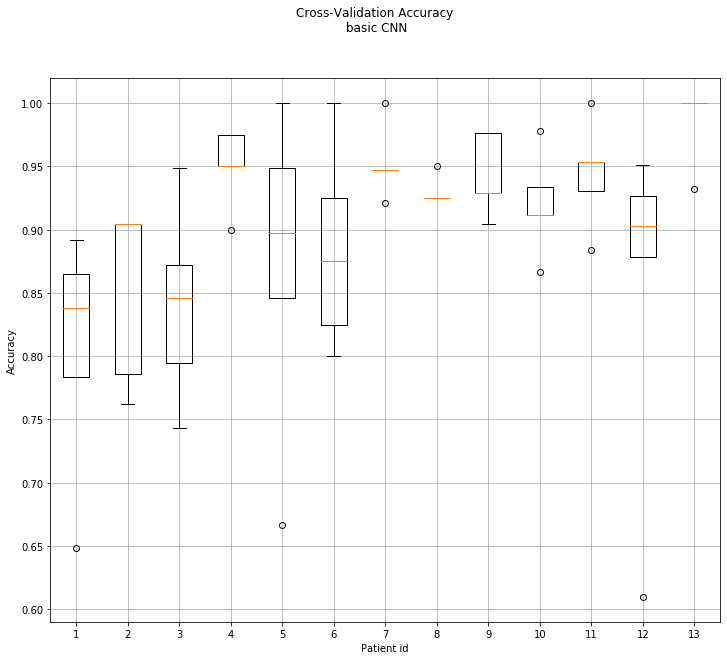

In [493]:
fig = plt.figure(figsize=(12,10))
plt.grid()
plt.boxplot(fold_vacc)
plt.suptitle('Cross-Validation Accuracy\n basic CNN')
ax = plt.gca()
plt.xlabel('Patient id')
plt.ylabel('Accuracy')
plt.savefig('fig.png')
plt.show()

# Image Time Window

## CNN Parallel Model (A)

In [8]:
class ParallelCNN(nn.Module):
    def __init__(self):
        super(ParallelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3,3,3, padding=1)
        self.conv2 = nn.Conv2d(3,3,5, padding=2)
        self.conv3 = nn.Conv2d(3,3,3, padding=1)
        self.conv4 = nn.Conv2d(3,3,5, padding=2)
        self.conv5 = nn.Conv2d(3,3,3, padding=1)
        self.conv6 = nn.Conv2d(3,3,5, padding=2)
        self.conv7 = nn.Conv2d(3,3,3, padding=1)
        self.conv8 = nn.Conv2d(3,3,5, padding=2)
        self.conv9 = nn.Conv2d(3,3,3, padding=1)
        self.conv10 = nn.Conv2d(3,3,5, padding=2)
        self.conv11 = nn.Conv2d(3,3,3, padding=1)
        self.conv12 = nn.Conv2d(3,3,5, padding=2)
        self.conv13 = nn.Conv2d(3,3,3, padding=1)
        self.conv14 = nn.Conv2d(3,3,5, padding=2)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(3549,512)
        self.fc2 = nn.Linear(512,4)
        self.max = nn.Softmax()
    
    def forward(self, x):
        batch_size = x.shape[0]
        x[:,0] = F.relu(self.conv1(x[:,0]))
        x[:,1] = F.relu(self.conv3(x[:,1]))
        x[:,2] = F.relu(self.conv5(x[:,2]))
        x[:,3] = F.relu(self.conv7(x[:,3]))
        x[:,4] = F.relu(self.conv9(x[:,4]))
        x[:,5] = F.relu(self.conv11(x[:,5]))
        x[:,6] = F.relu(self.conv13(x[:,6]))
        x[:,0] = F.relu(self.conv2(x[:,0]))
        x[:,1] = F.relu(self.conv4(x[:,1]))
        x[:,2] = F.relu(self.conv6(x[:,2]))
        x[:,3] = F.relu(self.conv8(x[:,3]))
        x[:,4] = F.relu(self.conv10(x[:,4]))
        x[:,5] = F.relu(self.conv12(x[:,5]))
        x[:,6] = F.relu(self.conv14(x[:,6]))
        x = x[:,:,:,3:29,3:29]
        x = x.reshape(batch_size, x.shape[2], x.shape[1]*x.shape[3],-1) # img reshape
        x = self.pool(x)
        x = x.view(batch_size,-1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.max(x)
        return x

In [10]:
p = 0
n_fold = 5    
n_patient = len(np.unique(Patient))
fold_vloss = np.zeros((n_fold,n_patient))
fold_loss = np.zeros((n_fold,n_patient))
fold_vacc = np.zeros((n_fold,n_patient))
fold_acc = np.zeros((n_fold,n_patient))
for patient in np.unique(Patient):
    id_patient = np.arange(len(tmp))[Patient==patient]

    length = len(id_patient)
    
    train_id, test_id = kfold(length,n_fold)
    
    for fold in range(n_fold):
        X_train = tmp[id_patient[train_id[fold]]]
        X_test = tmp[id_patient[test_id[fold]]]
        y_train = Label[id_patient[train_id[fold]]]
        y_test = Label[id_patient[test_id[fold]]] 

        print("Begin Training Fold %d/%d\t of Patient %d" % 
             (fold+1,n_fold, patient))

        CNN = ParallelCNN().cuda(0)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(CNN.parameters(), lr=0.001, momentum=0.9)

        n_epochs = 30
        for epoch in range(n_epochs):
            running_loss = 0.0
            batchsize = 4
            for i in range(int(len(y_train)/batchsize)):
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = CNN(torch.from_numpy(X_train[i:i+batchsize]).to(torch.float32).cuda())
                loss = criterion(outputs, torch.from_numpy(y_train[i:i+batchsize]).to(torch.long).cuda())
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            #acc
            _, idx = torch.max(CNN(torch.from_numpy(X_train[:]).to(torch.float32).cuda()).data,1)
            acc = (idx == torch.from_numpy(y_train).cuda()).sum().item()/len(y_train)

            #val Loss
            val_outputs = CNN(torch.from_numpy(X_test[:]).to(torch.float32).cuda())
            val_loss = criterion(val_outputs, torch.from_numpy(y_test[:]).to(torch.long).cuda())
            _, idx = torch.max(val_outputs.data,1)
            val_acc = (idx == torch.from_numpy(y_test).cuda()).sum().item()/len(y_test)

            if epoch%5==0:
                print('[%d, %3d] loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
             (epoch+1, n_epochs, running_loss/i, float(acc), val_loss, val_acc))
        fold_vloss[fold, p ] = val_loss.item()
        fold_loss[fold, p] = running_loss/i
        fold_vacc[fold, p] = val_acc
        fold_acc[fold, p] = acc
        print('Finish Training Fold %d/%d\t of Patient %d' % 
             (fold+1,n_fold, patient))
    print('loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
                 (np.mean(fold_loss[:,p]), np.mean(fold_acc[:,p]), np.mean(fold_vloss[:,p]),np.mean(fold_vacc[:,p])))
    
    p = p + 1

c:\users\victo\.conda\envs\pytorch_eeg\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Begin Training Fold 1/5	 of Patient 1
[1,  30] loss: 1.414	Accuracy : 0.517		val-loss: 1.359	val-Accuracy : 0.459
[6,  30] loss: 1.117	Accuracy : 0.748		val-loss: 1.088	val-Accuracy : 0.757
[11,  30] loss: 0.913	Accuracy : 0.830		val-loss: 0.968	val-Accuracy : 0.784
[16,  30] loss: 0.862	Accuracy : 0.830		val-loss: 0.925	val-Accuracy : 0.811


KeyboardInterrupt: 

### Peresented Results

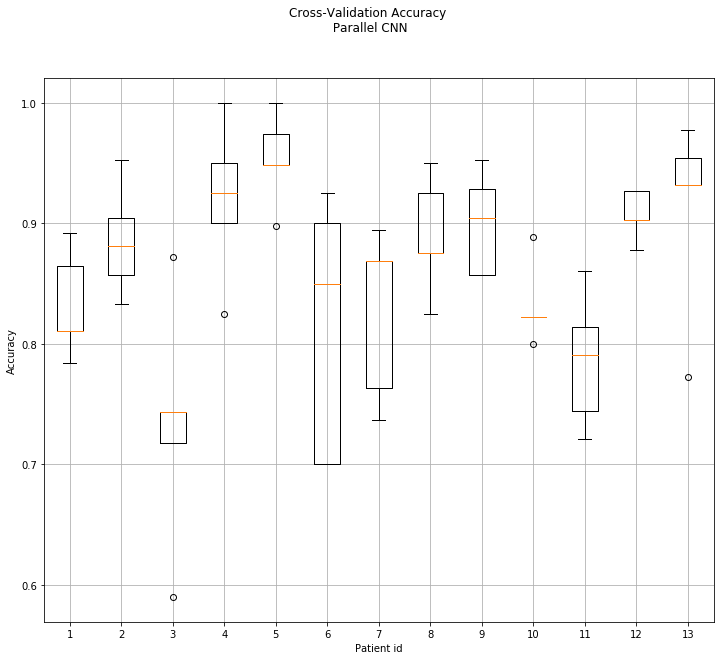

In [91]:
sio.savemat('Result/Res_ParallelCNN.mat',{"loss":fold_loss,"acc":fold_acc,"val loss":fold_vloss,"val acc":fold_vacc})

fig = plt.figure(figsize=(12,10))
plt.grid()
plt.boxplot(fold_vacc)
plt.suptitle('Cross-Validation Accuracy\n Parallel CNN')
ax = plt.gca()
plt.xlabel('Patient id')
plt.ylabel('Accuracy')
plt.savefig('Result/ParallelCNN.png')
plt.show()

## CNN Temporal Model (B)

In [276]:
class TemporalCNN(nn.Module):
    def __init__(self):
        super(TemporalCNN, self).__init__()
        self.conv1 = nn.Conv2d(3,3,3)
        self.conv2 = nn.Conv2d(3,3,5)
        self.conv3 = nn.Conv2d(3,3,3)
        self.conv4 = nn.Conv2d(3,3,5)
        self.conv5 = nn.Conv2d(3,3,3)
        self.conv6 = nn.Conv2d(3,3,5)
        self.conv7 = nn.Conv2d(3,3,3)
        self.conv8 = nn.Conv2d(3,3,5)
        self.conv9 = nn.Conv2d(3,3,3)
        self.conv10 = nn.Conv2d(3,3,5)
        self.conv11 = nn.Conv2d(3,3,3)
        self.conv12 = nn.Conv2d(3,3,5)
        self.conv13 = nn.Conv2d(3,3,3)
        self.conv14 = nn.Conv2d(3,3,5)     
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)   
        self.conv15 = nn.Conv2d(3,3,5)
        self.conv16 = nn.Conv2d(3,3,7)
        self.fc1 = nn.Linear(120,512)
        self.fc2 = nn.Linear(512,4)
        self.max = nn.Softmax()
    
    def forward(self, x):
        batch_size = x.shape[0]
        tmp = torch.zeros(batch_size, x.shape[1], x.shape[2],26,26).cuda()
        tmp[:,0] = F.relu(self.conv2(F.relu(self.conv1(x[:,0]))))
        tmp[:,1] = F.relu(self.conv4(F.relu(self.conv3(x[:,1]))))
        tmp[:,2] = F.relu(self.conv6(F.relu(self.conv5(x[:,2]))))
        tmp[:,3] = F.relu(self.conv8(F.relu(self.conv7(x[:,3]))))
        tmp[:,4] = F.relu(self.conv10(F.relu(self.conv9(x[:,4]))))
        tmp[:,5] = F.relu(self.conv12(F.relu(self.conv11(x[:,5]))))
        tmp[:,6] = F.relu(self.conv14(F.relu(self.conv13(x[:,6]))))
        x = torch.zeros(batch_size, x.shape[1], x.shape[2],26,26).cuda()
        for i in range(7):
            x[:,i] = tmp[:,i]
        #x[:,0] = F.relu(self.conv1(x[:,0]))
        #x[:,1] = F.relu(self.conv3(x[:,1]))
        #x[:,2] = F.relu(self.conv5(x[:,2]))
        #x[:,3] = F.relu(self.conv7(x[:,3]))
        #x[:,4] = F.relu(self.conv9(x[:,4]))
        #x[:,5] = F.relu(self.conv11(x[:,5]))
        #x[:,6] = F.relu(self.conv13(x[:,6]))
        #x[:,0] = F.relu(self.conv2(x[:,0]))
        #x[:,1] = F.relu(self.conv4(x[:,1]))
        #x[:,2] = F.relu(self.conv6(x[:,2]))
        #x[:,3] = F.relu(self.conv8(x[:,3]))
        #x[:,4] = F.relu(self.conv10(x[:,4]))
        #x[:,5] = F.relu(self.conv12(x[:,5]))
        #x[:,6] = F.relu(self.conv14(x[:,6]))
        #x = x[:,:,:,3:29,3:29]
        #tmp = torch.zeros(batch_size, x.shape[2], x.shape[1]*x.shape[3],x.shape[4]).cuda()
        #for i in range(x.shape[1]):
        #    tmp[:,:,i*x.shape[3]:(i+1)*x.shape[3], :] = x[:,i]
        x = x.reshape(batch_size, x.shape[2], x.shape[1]*x.shape[3],-1) # img reshape
        x = self.pool1(x)
        x = F.relu(self.conv15(x))
        x = F.relu(self.conv16(x))
        x = self.pool2(x)
        x = x.view(batch_size,-1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.max(x)
        return x

In [277]:
net = TemporalCNN().cuda()
net(torch.from_numpy(tmp[0:2]).to(torch.float32).cuda())

c:\users\victo\.conda\envs\pytorch_eeg\lib\site-packages\ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[0.2572, 0.2522, 0.2505, 0.2401],
        [0.2591, 0.2499, 0.2525, 0.2385]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [280]:
    if opti=='SGD':
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    elif opti =='Adam':
        optimizer = optip = 0
n_fold = 5    
n_patient = len(np.unique(Patient))
fold_vloss = np.zeros((n_fold,n_patient))
fold_loss = np.zeros((n_fold,n_patient))
fold_vacc = np.zeros((n_fold,n_patient))
fold_acc = np.zeros((n_fold,n_patient))
for patient in np.unique(Patient):
    id_patient = np.arange(len(tmp))[Patient==patient]

    length = len(id_patient)
    
    train_id, test_id = kfold(length,n_fold)
    
    for fold in range(n_fold):
        X_train = tmp[id_patient[train_id[fold]]]
        X_test = tmp[id_patient[test_id[fold]]]
        y_train = Label[id_patient[train_id[fold]]]
        y_test = Label[id_patient[test_id[fold]]] 

        print("Begin Training Fold %d/%d\t of Patient %d" % 
             (fold+1,n_fold, patient))

        CNN = TemporalCNN().cuda(0)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(CNN.parameters(), lr=0.001)
#        optimizer = optim.SGD(CNN.parameters(), lr=0.001, momentum=0.9)

        n_epochs = 100
        for epoch in range(n_epochs):
            running_loss = 0.0
            batchsize = 4
            for i in range(int(len(y_train)/batchsize)):
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = CNN(torch.from_numpy(X_train[i:i+batchsize]).to(torch.float32).cuda())
                loss = criterion(outputs, torch.from_numpy(y_train[i:i+batchsize]).to(torch.long).cuda())
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            #acc
            _, idx = torch.max(CNN(torch.from_numpy(X_train[:]).to(torch.float32).cuda()).data,1)
            acc = (idx == torch.from_numpy(y_train).cuda()).sum().item()/len(y_train)

            #val Loss
            val_outputs = CNN(torch.from_numpy(X_test[:]).to(torch.float32).cuda())
            val_loss = criterion(val_outputs, torch.from_numpy(y_test[:]).to(torch.long).cuda())
            _, idx = torch.max(val_outputs.data,1)
            val_acc = (idx == torch.from_numpy(y_test).cuda()).sum().item()/len(y_test)

            if epoch%10==0:
                print('[%d, %3d] loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
             (epoch+1, n_epochs, running_loss/i, float(acc), val_loss, val_acc))
        fold_vloss[fold, p ] = val_loss.item()
        fold_loss[fold, p] = running_loss/i
        fold_vacc[fold, p] = val_acc
        fold_acc[fold, p] = acc
        print('Finish Training Fold %d/%d\t of Patient %d' % 
             (fold+1,n_fold, patient))
    print('loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
                 (np.mean(fold_loss[:,p]), np.mean(fold_acc[:,p]), np.mean(fold_vloss[:,p]),np.mean(fold_vacc[:,p])))
    
    p = p + 1

Begin Training Fold 1/5	 of Patient 1


c:\users\victo\.conda\envs\pytorch_eeg\lib\site-packages\ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1, 100] loss: 1.424	Accuracy : 0.327		val-loss: 1.384	val-Accuracy : 0.243
[11, 100] loss: 1.422	Accuracy : 0.320		val-loss: 1.384	val-Accuracy : 0.270
[21, 100] loss: 1.420	Accuracy : 0.320		val-loss: 1.384	val-Accuracy : 0.270
[31, 100] loss: 1.418	Accuracy : 0.320		val-loss: 1.383	val-Accuracy : 0.270
[41, 100] loss: 1.417	Accuracy : 0.320		val-loss: 1.383	val-Accuracy : 0.270
[51, 100] loss: 1.415	Accuracy : 0.320		val-loss: 1.383	val-Accuracy : 0.270
[61, 100] loss: 1.413	Accuracy : 0.320		val-loss: 1.383	val-Accuracy : 0.270
[71, 100] loss: 1.411	Accuracy : 0.320		val-loss: 1.383	val-Accuracy : 0.270
[81, 100] loss: 1.409	Accuracy : 0.320		val-loss: 1.383	val-Accuracy : 0.270
[91, 100] loss: 1.408	Accuracy : 0.320		val-loss: 1.383	val-Accuracy : 0.270
Finish Training Fold 1/5	 of Patient 1
Begin Training Fold 2/5	 of Patient 1
[1, 100] loss: 1.427	Accuracy : 0.265		val-loss: 1.390	val-Accuracy : 0.216


KeyboardInterrupt: 

### Peresented Results

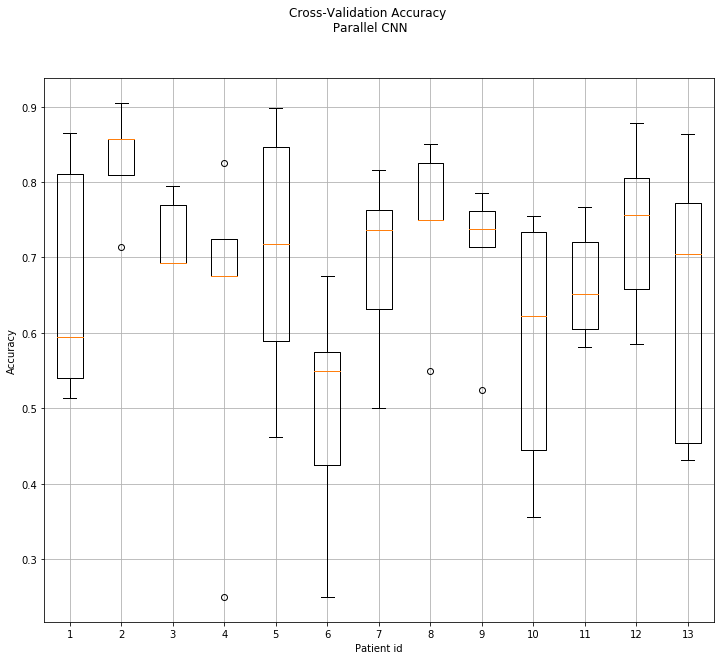

In [35]:
sio.savemat('Result/Res_TemporalCNN.mat',{"loss":fold_loss,"acc":fold_acc,"val loss":fold_vloss,"val acc":fold_vacc})

fig = plt.figure(figsize=(12,10))
plt.grid()
plt.boxplot(fold_vacc)
plt.suptitle('Cross-Validation Accuracy\n Parallel CNN')
ax = plt.gca()
plt.xlabel('Patient id')
plt.ylabel('Accuracy')
plt.savefig('Result/ParallelCNN.png')
plt.show()

In [ ]:
sio.savemat('Result/Res_2dTemporalCNN.mat',{"loss":fold_loss,"acc":fold_acc,"val loss":fold_vloss,"val acc":fold_vacc})

fig = plt.figure(figsize=(12,10))
plt.grid()
plt.boxplot(fold_vacc)
plt.suptitle('Cross-Validation Accuracy\n Parallel CNN')
ax = plt.gca()
plt.xlabel('Patient id')
plt.ylabel('Accuracy')
plt.savefig('Result/2dParallelCNN.png')
plt.show()

## LSTM Model (C)

In [238]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.conv1 = nn.Conv2d(3,3,3)
        self.conv2 = nn.Conv2d(3,3,5)
        self.conv3 = nn.Conv2d(3,3,3)
        self.conv4 = nn.Conv2d(3,3,5)
        self.conv5 = nn.Conv2d(3,3,3)
        self.conv6 = nn.Conv2d(3,3,5)
        self.conv7 = nn.Conv2d(3,3,3)
        self.conv8 = nn.Conv2d(3,3,5)
        self.conv9 = nn.Conv2d(3,3,3)
        self.conv10 = nn.Conv2d(3,3,5)
        self.conv11 = nn.Conv2d(3,3,3)
        self.conv12 = nn.Conv2d(3,3,5)
        self.conv13 = nn.Conv2d(3,3,3)
        self.conv14 = nn.Conv2d(3,3,5)     
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)   
        self.rnn1 = nn.LSTMCell(507,2)
        self.fc1 = nn.Linear(120,512)
        self.fc2 = nn.Linear(512,4)
        self.max = nn.Softmax()
    
    def forward(self, x):
        batch_size = x.shape[0]
        tmp = torch.zeros(batch_size, x.shape[1], x.shape[2],26,26).cuda()
        tmp[:,0] = F.relu(self.conv2(F.relu(self.conv1(x[:,0]))))
        tmp[:,1] = F.relu(self.conv4(F.relu(self.conv3(x[:,1]))))
        tmp[:,2] = F.relu(self.conv6(F.relu(self.conv5(x[:,2]))))
        tmp[:,3] = F.relu(self.conv8(F.relu(self.conv7(x[:,3]))))
        tmp[:,4] = F.relu(self.conv10(F.relu(self.conv9(x[:,4]))))
        tmp[:,5] = F.relu(self.conv12(F.relu(self.conv11(x[:,5]))))
        tmp[:,6] = F.relu(self.conv14(F.relu(self.conv13(x[:,6]))))
        x = torch.zeros(batch_size, x.shape[1], x.shape[2],13,13).cuda()
        for i in range(7):
            x[:,i] = self.pool1(tmp[:,i])
        x = x.view(batch_size,x.shape[1],-1)
        hx = torch.randn(1,batch_size)
        print(hx.size())
        print(x[:,0].size())
        self.rnn1(x[:,0],hx)
        x = x.reshape(batch_size, x.shape[2], x.shape[1]*x.shape[3],-1) # img reshape
        x = F.relu(self.conv15(x))
        x = F.relu(self.conv16(x))
        x = self.pool2(x)
        x = x.view(batch_size,-1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.max(x)
        return x

In [239]:
net = LSTM().cuda()
net(torch.from_numpy(tmp[0:2]).to(torch.float32).cuda())

torch.Size([1, 2])
torch.Size([2, 507])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [499]:
tot_img = Images[:,0,:,:]

In [393]:
id_patient = 

n_fold = 5
length = len(Mean_Images)

fold_vloss = np.zeros((n_fold,n_patient))
fold_loss = np.zeros((n_fold,n_patient))
fold_vacc = np.zeros((n_fold,n_patient))
fold_acc = np.zeros((n_fold,n_patient))

train_id, test_id = kfold(length,n_fold)
for fold in range(n_fold):
    X_train = Mean_Images[train_id[fold]]
    X_test = Mean_Images[test_id[fold]]    
    y_train = Label[train_id[fold]]
    y_test = Label[test_id[fold]]    
    
    print("Begin Training Fold %d/%d" % 
         (fold+1,n_fold))
    
    CNN = BasicCNN().cuda(0)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(CNN.parameters(), lr=0.001, momentum=0.9)
    
    n_epochs = 50
    for epoch in range(n_epochs):
        running_loss = 0.0
        batchsize = 10
        for i in range(int(len(y_train)/batchsize)):
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = CNN(torch.from_numpy(X_train[i:i+batchsize]).to(torch.float32).cuda())
            loss = criterion(outputs, torch.from_numpy(y_train[i:i+batchsize]).to(torch.long).cuda())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        #acc
        _, idx = torch.max(CNN(torch.from_numpy(X_train[:]).to(torch.float32).cuda()).data,1)
        acc = (idx == torch.from_numpy(y_train).cuda()).sum().item()/len(y_train)

        #val Loss
        val_outputs = CNN(torch.from_numpy(X_test[:]).to(torch.float32).cuda())
        val_loss = criterion(val_outputs, torch.from_numpy(y_test[:]).to(torch.long).cuda())
        _, idx = torch.max(val_outputs.data,1)
        val_acc = (idx == torch.from_numpy(y_test).cuda()).sum().item()/len(y_test)

        if epoch%10==0:
            print('[%d, %3d] loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
             (epoch+1, n_epochs, running_loss/i, float(acc), val_loss, val_acc))
    fold_vloss.append(val_loss)
    fold_loss.append(running_loss/i)
    fold_vacc.append(val_acc)
    fold_acc.append(acc)
    print('Finish Training Fold %d/%d' % 
         (fold+1,n_fold))

Begin Training Fold 1/5


c:\users\victo\.conda\envs\pytorch_eeg\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  50] loss: 1.385	Accuracy : 0.314		val-loss: 1.352	val-Accuracy : 0.309
[11,  50] loss: 0.841	Accuracy : 0.834		val-loss: 0.899	val-Accuracy : 0.845
[21,  50] loss: 0.826	Accuracy : 0.865		val-loss: 0.877	val-Accuracy : 0.867
[31,  50] loss: 0.804	Accuracy : 0.875		val-loss: 0.876	val-Accuracy : 0.869
[41,  50] loss: 0.797	Accuracy : 0.883		val-loss: 0.876	val-Accuracy : 0.867
Finish Training Fold 1/5
Begin Training Fold 2/5
[1,  50] loss: 1.386	Accuracy : 0.317		val-loss: 1.370	val-Accuracy : 0.277
[11,  50] loss: 0.869	Accuracy : 0.831		val-loss: 0.918	val-Accuracy : 0.828
[21,  50] loss: 0.842	Accuracy : 0.827		val-loss: 0.918	val-Accuracy : 0.824
[31,  50] loss: 0.825	Accuracy : 0.831		val-loss: 0.911	val-Accuracy : 0.826
[41,  50] loss: 0.824	Accuracy : 0.832		val-loss: 0.907	val-Accuracy : 0.833
Finish Training Fold 2/5
Begin Training Fold 3/5
[1,  50] loss: 1.384	Accuracy : 0.482		val-loss: 1.330	val-Accuracy : 0.485
[11,  50] loss: 0.871	Accuracy : 0.837		val-loss: 0.913	va

In [10]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3,32,(3,3),stride=(1,1), padding=1)
        self.conv2 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.conv3 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.conv4 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.pool = nn.MaxPool2d((2,2))
        self.conv5 = nn.Conv2d(32,64,(3,3),stride=(1,1),padding=1)
        self.conv6 = nn.Conv2d(64,64,(3,3),stride=(1,1),padding=1)
        self.conv7 = nn.Conv2d(64,128,(3,3),stride=(1,1),padding=1)
        self.fc1 = nn.Linear(507,512)
        self.fc2 = nn.Linear(512,4)
        self.max = nn.Softmax()
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = F.relu(self.conv7(x))
        x = self.pool(x)
        return x

In [51]:
64*3

192

In [36]:
class MaxCNN(nn.Module):
    def __init__(self, input_image, kernel=(3,3), stride=1, padding=1,max_kernel=(2,2)):
        super(MaxCNN, self).__init__()
        
        
        n_window = input_image.shape[1]
        n_channel = input_image.shape[2]
        
        self.conv1 = nn.Conv2d(n_channel,32,kernel,stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(32,32,kernel,stride=stride, padding=padding)
        self.conv3 = nn.Conv2d(32,32,kernel,stride=stride, padding=padding)
        self.conv4 = nn.Conv2d(32,32,kernel,stride=stride, padding=padding)
        self.pool1 = nn.MaxPool2d(max_kernel)
        self.conv5 = nn.Conv2d(32,64,kernel,stride=stride,padding=padding)
        self.conv6 = nn.Conv2d(64,64,kernel,stride=stride,padding=padding)
        self.conv7 = nn.Conv2d(64,128,kernel,stride=stride,padding=padding)
        
        self.pool = nn.MaxPool2d((n_window,1))
        self.drop = nn.Dropout(p=0.5)
        
        self.fc = nn.Linear(n_window*int(4*4*128/n_window),512)
        self.fc2 = nn.Linear(512,4)
        self.max = nn.LogSoftmax()

    def forward(self, x):
        if x.get_device() == 0:
            tmp = torch.zeros(x.shape[0],x.shape[1],128,4,4).cuda()
        else:
            tmp = torch.zeros(x.shape[0],x.shape[1],128,4,4).cpu()
        for i in range(7):
            tmp[:,i] = self.pool1( F.relu(self.conv7(self.pool1(F.relu(self.conv6(F.relu(self.conv5(self.pool1( F.relu(self.conv4(F.relu(self.conv3( F.relu(self.conv2(F.relu(self.conv1(x[:,i])))))))))))))))))
        x = tmp.reshape(x.shape[0], x.shape[1],4*128*4,1)
        x = self.pool(x)
        x = x.view(x.shape[0],-1)
        x = self.fc2(self.fc(x))
        x = self.max(x)
        return x

In [38]:
class MaxCNN(nn.Module):
    def __init__(self):
        super(MaxCNN, self).__init__()
        
        
        self.conv1 = nn.Conv2d(3,32,(3,3),stride=(1,1), padding=1)
        self.conv2 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.conv3 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.conv4 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv5 = nn.Conv2d(32,64,(3,3),stride=(1,1),padding=1)
        self.conv6 = nn.Conv2d(64,64,(3,3),stride=(1,1),padding=1)
        self.conv7 = nn.Conv2d(64,128,(3,3),stride=(1,1),padding=1)
        
        
        self.pool = nn.MaxPool2d((7,1))
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(2044,512)
        self.fc2 = nn.Linear(512,4)
        self.max = nn.LogSoftmax()
        
    def forward(self, x):
        if x.get_device() == 0:
            tmp = torch.zeros(x.shape[0],x.shape[1],128,4,4).cuda()
        else:
            tmp = torch.zeros(x.shape[0],x.shape[1],128,4,4).cpu()
        for i in range(7):
            tmp[:,i] = self.pool1( F.relu(self.conv7(self.pool1(F.relu(self.conv6(F.relu(self.conv5(self.pool1( F.relu(self.conv4(F.relu(self.conv3( F.relu(self.conv2(F.relu(self.conv1(x[:,i])))))))))))))))))
        x = tmp.reshape(x.shape[0], x.shape[1],4*128*4,1)
        x = self.pool(x)
        x = x.view(x.shape[0],-1)
        #x = self.drop(x)
        x = self.fc2(self.fc(x))
        x = self.max(x)
        return x

In [43]:
p = 0
n_rep = 5    
n_patient = len(np.unique(Patient))
fold_vloss = np.zeros((n_rep,n_patient))
fold_loss = np.zeros((n_rep,n_patient))
fold_vacc = np.zeros((n_rep,n_patient))
fold_acc = np.zeros((n_rep,n_patient))

for patient in np.unique(Patient):
    id_patient = np.arange(len(tmp))[Patient==patient]
    id_train = np.arange(len(tmp))[Patient!=patient]
    
    for rep in range(n_rep):
        np.random.shuffle(id_patient)
        np.random.shuffle(id_train)
        
        X_train = tmp[id_train]
        X_test = tmp[id_patient]
        y_train = Label[id_train]
        y_test = Label[id_patient]
        
        print("Begin Training rep %d/%d\t of Patient %d" % 
             (rep+1,n_rep, patient))
        
        CNN = MaxCNN().cuda()
        criterion = nn.NLLLoss()
        optimizer = optim.SGD(CNN.parameters(), lr=0.01)
        
        n_epochs = 45
        for epoch in range(n_epochs):
            running_loss = 0.0
            batchsize = 32
            for i in range(int(len(y_train)/batchsize)):
                
                CNN.to(torch.device("cuda"))
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = CNN(torch.from_numpy(X_train[i*batchsize:(i+1)*batchsize]).to(torch.float32).cuda())
                loss = criterion(outputs, torch.from_numpy(y_train[i*batchsize:(i+1)*batchsize]).to(torch.long).cuda())
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
            if epoch==50:
                cnn_cpu = CNN.to(torch.device("cuda"))

                check_id = np.arange(2000)
                np.random.shuffle(check_id)
                #acc
                acc = np.zeros(len(y_train))
                for j in range(int(len(acc)/batchsize)+1):
                    _, idx = torch.max(cnn_cpu(torch.from_numpy(X_train[j*batchsize:(j+1)*batchsize]).to(torch.float32)).data,1)
                    acc[j*batchsize:(j+1)*batchsize] = (idx == torch.from_numpy(y_train[j*batchsize:(j+1)*batchsize])).numpy() + 0 
                acc = np.mean(acc)
                
                #validation
                val_acc = np.zeros(len(y_test))
                val_loss = []
                for j in range(int(len(val_acc)/batchsize)+1):
                    val_outputs = cnn_cpu(torch.from_numpy(X_test[j*batchsize:(j+1)*batchsize]).to(torch.float32))
                    _, idx = torch.max(val_outputs.data,1)
                    val_loss.append(criterion(val_outputs, torch.from_numpy(y_test[j*batchsize:(j+1)*batchsize]).to(torch.long)).item())
                    val_acc[j*batchsize:(j+1)*batchsize] = (idx.cpu().numpy() == y_test[j*batchsize:(j+1)*batchsize])+0
                val_acc = np.mean(val_acc)
                val_loss = np.mean(val_loss)

                print('[%d, %3d] loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
             (epoch+1, n_epochs, running_loss/i, float(acc), val_loss, val_acc))

        fold_vloss[rep, p ] = val_loss
        fold_loss[rep, p] = running_loss/i
        fold_vacc[rep, p] = val_acc
        fold_acc[rep, p] = acc
      
    
    print('loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
                 (np.mean(fold_loss[:,p]), np.mean(fold_acc[:,p]), np.mean(fold_vloss[:,p]),np.mean(fold_vacc[:,p])))
    
    p = p + 1

Begin Training rep 1/5	 of Patient 1


c:\users\victo\.conda\envs\pytorch_eeg\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

In [8]:
p = 12
n_rep = 5    
n_patient = len(np.unique(Patient))
fold_vloss = np.zeros((n_rep,n_patient))
fold_loss = np.zeros((n_rep,n_patient))
fold_vacc = np.zeros((n_rep,n_patient))
fold_acc = np.zeros((n_rep,n_patient))

for patient in np.unique(Patient):
    patient = patient + 13
    id_patient = np.arange(len(tmp))[Patient==patient]
    id_train = np.arange(len(tmp))[Patient!=patient]
    
    for rep in range(n_rep):
        np.random.shuffle(id_patient)
        np.random.shuffle(id_train)
        
        X_train = tmp[id_train]
        X_test = tmp[id_patient]
        y_train = Label[id_train]
        y_test = Label[id_patient]
        
        print("Begin Training rep %d/%d\t of Patient %d" % 
             (rep+1,n_rep, patient))
        
        CNN = MaxCNN().cuda()
        criterion = nn.NLLLoss()
        optimizer = optim.SGD(CNN.parameters(), lr=0.01)
        
        n_epochs = 45
        for epoch in range(n_epochs):
            running_loss = 0.0
            batchsize = 32
            for i in range(int(len(y_train)/batchsize)):
                
                CNN.to(torch.device("cuda"))
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = CNN(torch.from_numpy(X_train[i*batchsize:(i+1)*batchsize]).to(torch.float32).cuda())
                loss = criterion(outputs, torch.from_numpy(y_train[i*batchsize:(i+1)*batchsize]).to(torch.long).cuda())
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
            if epoch%5==0:
                cnn_cpu = CNN.to(torch.device("cpu"))

                check_id = np.arange(2000)
                np.random.shuffle(check_id)
                
                #acc
                acc = np.zeros(len(y_train))
                for j in range(int(len(acc)/batchsize)+1):
                    _, idx = torch.max(cnn_cpu(torch.from_numpy(X_train[j*batchsize:(j+1)*batchsize]).to(torch.float32)).data,1)
                    acc[j*batchsize:(j+1)*batchsize] = (idx == torch.from_numpy(y_train[j*batchsize:(j+1)*batchsize])).numpy() + 0 
                acc = np.mean(acc)
                
                #validation
                val_acc = np.zeros(len(y_test))
                val_loss = []
                for j in range(int(len(val_acc)/batchsize)+1):
                    val_outputs = cnn_cpu(torch.from_numpy(X_test[j*batchsize:(j+1)*batchsize]).to(torch.float32))
                    _, idx = torch.max(val_outputs.data,1)
                    val_loss.append(criterion(val_outputs, torch.from_numpy(y_test[j*batchsize:(j+1)*batchsize]).to(torch.long)).item())
                    val_acc[j*batchsize:(j+1)*batchsize] = (idx.cpu().numpy() == y_test[j*batchsize:(j+1)*batchsize])+0
                val_acc = np.mean(val_acc)
                val_loss = np.mean(val_loss)

                print('[%d, %3d] loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
             (epoch+1, n_epochs, running_loss/i, float(acc), val_loss, val_acc))

        fold_vloss[rep, p ] = val_loss
        fold_loss[rep, p] = running_loss/i
        fold_vacc[rep, p] = val_acc
        fold_acc[rep, p] = acc
      
    
    print('loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
                 (np.mean(fold_loss[:,p]), np.mean(fold_acc[:,p]), np.mean(fold_vloss[:,p]),np.mean(fold_vacc[:,p])))
    
    p = p + 1

Begin Training rep 1/5	 of Patient 11


c:\users\victo\.conda\envs\pytorch_eeg\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  45] loss: 1.402	Accuracy : 0.286		val-loss: 1.379	val-Accuracy : 0.258
[6,  45] loss: 1.397	Accuracy : 0.286		val-loss: 1.368	val-Accuracy : 0.258
[11,  45] loss: 1.207	Accuracy : 0.482		val-loss: 0.958	val-Accuracy : 0.516
[16,  45] loss: 1.054	Accuracy : 0.578		val-loss: 0.800	val-Accuracy : 0.613
[21,  45] loss: 0.941	Accuracy : 0.656		val-loss: 0.727	val-Accuracy : 0.689
[26,  45] loss: 0.793	Accuracy : 0.741		val-loss: 0.627	val-Accuracy : 0.787
[31,  45] loss: 0.565	Accuracy : 0.845		val-loss: 0.306	val-Accuracy : 0.902
[36,  45] loss: 0.332	Accuracy : 0.887		val-loss: 0.214	val-Accuracy : 0.933
[41,  45] loss: 0.232	Accuracy : 0.912		val-loss: 0.218	val-Accuracy : 0.920
Begin Training rep 2/5	 of Patient 11
[1,  45] loss: 1.401	Accuracy : 0.358		val-loss: 1.379	val-Accuracy : 0.387
[6,  45] loss: 1.389	Accuracy : 0.286		val-loss: 1.365	val-Accuracy : 0.258
[11,  45] loss: 1.136	Accuracy : 0.548		val-loss: 1.012	val-Accuracy : 0.578
[16,  45] loss: 1.019	Accuracy : 0.606		va

RuntimeError: non-empty 3D or 4D input tensor expected but got ndim: 4

In [14]:
p = 12
n_rep = 5    
n_patient = len(np.unique(Patient))
fold_vloss = np.zeros((n_rep,n_patient))
fold_loss = np.zeros((n_rep,n_patient))
fold_vacc = np.zeros((n_rep,n_patient))
fold_acc = np.zeros((n_rep,n_patient))

for patient in np.unique(Patient):
    patient = patient + 13
    id_patient = np.arange(len(tmp))[Patient==patient]
    id_train = np.arange(len(tmp))[Patient!=patient]
    
    for rep in range(n_rep):
        np.random.shuffle(id_patient)
        np.random.shuffle(id_train)
        
        X_train = tmp[id_train]
        X_test = tmp[id_patient]
        y_train = Label[id_train]
        y_test = Label[id_patient]
        
        print("Begin Training rep %d/%d\t of Patient %d" % 
             (rep+1,n_rep, patient))
        
        CNN = MaxCNN().cuda()
        criterion = nn.NLLLoss()
        optimizer = optim.SGD(CNN.parameters(), lr=0.01)
        
        n_epochs = 45
        for epoch in range(n_epochs):
            running_loss = 0.0
            batchsize = 32
            for i in range(int(len(y_train)/batchsize)):
                
                CNN.to(torch.device("cuda"))
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = CNN(torch.from_numpy(X_train[i*batchsize:(i+1)*batchsize]).to(torch.float32).cuda())
                loss = criterion(outputs, torch.from_numpy(y_train[i*batchsize:(i+1)*batchsize]).to(torch.long).cuda())
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
            if epoch%5==0:
                cnn_cpu = CNN.to(torch.device("cpu"))

                check_id = np.arange(2000)
                np.random.shuffle(check_id)
                
                #acc
                acc = np.zeros(len(y_train))
                for j in range(int(len(acc)/batchsize)+1):
                    _, idx = torch.max(cnn_cpu(torch.from_numpy(X_train[j*batchsize:(j+1)*batchsize]).to(torch.float32)).data,1)
                    acc[j*batchsize:(j+1)*batchsize] = (idx == torch.from_numpy(y_train[j*batchsize:(j+1)*batchsize])).numpy() + 0 
                acc = np.mean(acc)
                
                #validation
                val_acc = np.zeros(len(y_test))
                val_loss = []
                for j in range(int(len(val_acc)/batchsize)+1):
                    val_outputs = cnn_cpu(torch.from_numpy(X_test[j*batchsize:(j+1)*batchsize]).to(torch.float32))
                    _, idx = torch.max(val_outputs.data,1)
                    val_loss.append(criterion(val_outputs, torch.from_numpy(y_test[j*batchsize:(j+1)*batchsize]).to(torch.long)).item())
                    val_acc[j*batchsize:(j+1)*batchsize] = (idx.cpu().numpy() == y_test[j*batchsize:(j+1)*batchsize])+0
                val_acc = np.mean(val_acc)
                val_loss = np.mean(val_loss)

                print('[%d, %3d] loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
             (epoch+1, n_epochs, running_loss/i, float(acc), val_loss, val_acc))

        fold_vloss[rep, p ] = val_loss
        fold_loss[rep, p] = running_loss/i
        fold_vacc[rep, p] = val_acc
        fold_acc[rep, p] = acc
      
    
    print('loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
                 (np.mean(fold_loss[:,p]), np.mean(fold_acc[:,p]), np.mean(fold_vloss[:,p]),np.mean(fold_vacc[:,p])))
    
    p = p + 1

Begin Training rep 1/5	 of Patient 14


c:\users\victo\.conda\envs\pytorch_eeg\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  45] loss: 1.403	Accuracy : 0.286		val-loss: 1.383	val-Accuracy : 0.273
[6,  45] loss: 1.397	Accuracy : 0.284		val-loss: 1.380	val-Accuracy : 0.278
[11,  45] loss: 1.243	Accuracy : 0.464		val-loss: 1.235	val-Accuracy : 0.464
[16,  45] loss: 1.071	Accuracy : 0.552		val-loss: 1.099	val-Accuracy : 0.565
[21,  45] loss: 0.970	Accuracy : 0.621		val-loss: 0.996	val-Accuracy : 0.612
[26,  45] loss: 0.838	Accuracy : 0.715		val-loss: 0.963	val-Accuracy : 0.641
[31,  45] loss: 0.609	Accuracy : 0.831		val-loss: 0.720	val-Accuracy : 0.785
[36,  45] loss: 0.392	Accuracy : 0.906		val-loss: 0.601	val-Accuracy : 0.656
[41,  45] loss: 0.243	Accuracy : 0.912		val-loss: 0.485	val-Accuracy : 0.675
Begin Training rep 2/5	 of Patient 14
[1,  45] loss: 1.402	Accuracy : 0.284		val-loss: 1.383	val-Accuracy : 0.278
[6,  45] loss: 1.398	Accuracy : 0.284		val-loss: 1.381	val-Accuracy : 0.278
[11,  45] loss: 1.338	Accuracy : 0.398		val-loss: 1.318	val-Accuracy : 0.469
[16,  45] loss: 1.081	Accuracy : 0.574		va

IndexError: index 13 is out of bounds for axis 1 with size 13

In [ ]:
sio.savemat('Result/Res_MaxPoolCNN.mat',{"loss":fold_loss,"acc":fold_acc,"val loss":fold_vloss,"val acc":fold_vacc})

fig = plt.figure(figsize=(12,10))
plt.grid()
plt.boxplot(fold_vacc)
plt.suptitle('Cross-Validation Accuracy\n MaxPool CNN')
ax = plt.gca()
plt.xlabel('Patient id')
plt.ylabel('Accuracy')
plt.savefig('Result/MaxPoolCNN.png')
plt.show()

In [15]:
class TempCNN(nn.Module):
    def __init__(self):
        super(TempCNN, self).__init__()
        
        
        self.conv1 = nn.Conv2d(3,32,(3,3),stride=(1,1), padding=1)
        self.conv2 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.conv3 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.conv4 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv5 = nn.Conv2d(32,64,(3,3),stride=(1,1),padding=1)
        self.conv6 = nn.Conv2d(64,64,(3,3),stride=(1,1),padding=1)
        self.conv7 = nn.Conv2d(64,128,(3,3),stride=(1,1),padding=1)
        
        self.conv8 = nn.Conv1d(7,64,(4*4*128,3),stride=(1,1),padding=1)
        
        self.pool = nn.MaxPool2d((7,1))
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(192,4)
        self.max = nn.LogSoftmax()
        
    def forward(self, x):
        if x.get_device() == 0:
            tmp = torch.zeros(x.shape[0],x.shape[1],128,4,4).cuda()
        else:
            tmp = torch.zeros(x.shape[0],x.shape[1],128,4,4).cpu()
        for i in range(7):
            tmp[:,i] = self.pool1( F.relu(self.conv7(self.pool1(F.relu(self.conv6(F.relu(self.conv5(self.pool1( F.relu(self.conv4(F.relu(self.conv3( F.relu(self.conv2(F.relu(self.conv1(x[:,i])))))))))))))))))
        x = tmp.reshape(x.shape[0], x.shape[1],4*128*4,1)
        x = F.relu(self.conv8(x))
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        x = self.max(x)
        return x

In [36]:
net = TempCNN().cuda()
net(torch.from_numpy(tmp[0:2]).to(torch.float32).cuda())

c:\users\victo\.conda\envs\pytorch_eeg\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-1.3924, -1.3307, -1.3637, -1.4631],
        [-1.3927, -1.3307, -1.3638, -1.4627]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)

In [41]:
p = 0
n_rep = 1  
n_patient = len(np.unique(Patient))
fold_vloss = np.zeros((n_rep,n_patient))
fold_loss = np.zeros((n_rep,n_patient))
fold_vacc = np.zeros((n_rep,n_patient))
fold_acc = np.zeros((n_rep,n_patient))

un = np.unique(Patient)
np.random.shuffle(un)
for patient in un:
    id_patient = np.arange(len(tmp))[Patient==patient]
    id_train = np.arange(len(tmp))[Patient!=patient]
    
    for rep in range(n_rep):
        np.random.shuffle(id_patient)
        np.random.shuffle(id_train)
        
        X_train = tmp[id_train]
        X_test = tmp[id_patient]
        y_train = Label[id_train]
        y_test = Label[id_patient]
        
        print("Begin Training rep %d/%d\t of Patient %d" % 
             (rep+1,n_rep, patient))
        
        CNN = TempCNN().cuda()
        criterion = nn.NLLLoss()
        optimizer = optim.SGD(CNN.parameters(), lr=0.01)
        
        n_epochs = 45
        for epoch in range(n_epochs):
            running_loss = 0.0
            batchsize = 32
            for i in range(int(len(y_train)/batchsize)):
                
                CNN.to(torch.device("cuda"))
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = CNN(torch.from_numpy(X_train[i*batchsize:(i+1)*batchsize]).to(torch.float32).cuda())
                loss = criterion(outputs, torch.from_numpy(y_train[i*batchsize:(i+1)*batchsize]).to(torch.long).cuda())
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
            if epoch%1==0:

                check_id = np.arange(2000)
                np.random.shuffle(check_id)
                
                #acc
                acc = np.zeros(len(y_train))
                for j in range(int(len(acc)/batchsize)+1):
                    _, idx = torch.max(CNN(torch.from_numpy(X_train[j*batchsize:(j+1)*batchsize]).to(torch.float32).cuda()).data,1)
                    acc[j*batchsize:(j+1)*batchsize] = (idx.to(torch.device("cpu")) == torch.from_numpy(y_train[j*batchsize:(j+1)*batchsize])).numpy() + 0 
                acc = np.mean(acc)
                
                #validation
                val_acc = np.zeros(len(y_test))
                val_loss = []
                for j in range(int(len(val_acc)/batchsize)+1):
                    val_outputs = CNN(torch.from_numpy(X_test[j*batchsize:(j+1)*batchsize]).to(torch.float32).cuda())
                    _, idx = torch.max(val_outputs.data,1)
                    val_loss.append(criterion(val_outputs, torch.from_numpy(y_test[j*batchsize:(j+1)*batchsize]).to(torch.long).cuda()).item())
                    val_acc[j*batchsize:(j+1)*batchsize] = (idx.cpu().numpy() == y_test[j*batchsize:(j+1)*batchsize])+0
                val_acc = np.mean(val_acc)
                val_loss = np.mean(val_loss)

                print('[%d, %3d] loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
             (epoch+1, n_epochs, running_loss/i, float(acc), val_loss, val_acc))
                
            if epoch==900:

                check_id = np.arange(2000)
                np.random.shuffle(check_id)
                
                #acc
                acc = np.zeros(len(y_train))
                for j in range(int(len(acc)/batchsize)+1):
                    _, idx = torch.max(cnn_cpu(torch.from_numpy(X_train[j*batchsize:(j+1)*batchsize]).to(torch.float32)).data,1)
                    acc[j*batchsize:(j+1)*batchsize] = (idx == torch.from_numpy(y_train[j*batchsize:(j+1)*batchsize])).numpy() + 0 
                acc = np.mean(acc)
                
                #validation
                val_acc = np.zeros(len(y_test))
                val_loss = []
                for j in range(int(len(val_acc)/batchsize)+1):
                    val_outputs = cnn_cpu(torch.from_numpy(X_test[j*batchsize:(j+1)*batchsize]).to(torch.float32))
                    _, idx = torch.max(val_outputs.data,1)
                    val_loss.append(criterion(val_outputs, torch.from_numpy(y_test[j*batchsize:(j+1)*batchsize]).to(torch.long)).item())
                    val_acc[j*batchsize:(j+1)*batchsize] = (idx.cpu().numpy() == y_test[j*batchsize:(j+1)*batchsize])+0
                val_acc = np.mean(val_acc)
                val_loss = np.mean(val_loss)

                print('[%d, %3d] loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
             (epoch+1, n_epochs, running_loss/i, float(acc), val_loss, val_acc))

        fold_vloss[rep, p ] = val_loss
        fold_loss[rep, p] = running_loss/i
        fold_vacc[rep, p] = val_acc
        fold_acc[rep, p] = acc
      
    
    print('loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
                 (np.mean(fold_loss[:,p]), np.mean(fold_acc[:,p]), np.mean(fold_vloss[:,p]),np.mean(fold_vacc[:,p])))
    
    p = p + 1

Begin Training rep 1/1	 of Patient 9


c:\users\victo\.conda\envs\pytorch_eeg\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  45] loss: 1.404	Accuracy : 0.283		val-loss: 1.380	val-Accuracy : 0.287
[2,  45] loss: 1.401	Accuracy : 0.283		val-loss: 1.376	val-Accuracy : 0.287
[3,  45] loss: 1.399	Accuracy : 0.283		val-loss: 1.373	val-Accuracy : 0.287
[4,  45] loss: 1.398	Accuracy : 0.283		val-loss: 1.371	val-Accuracy : 0.287
[5,  45] loss: 1.397	Accuracy : 0.283		val-loss: 1.370	val-Accuracy : 0.287
[6,  45] loss: 1.396	Accuracy : 0.283		val-loss: 1.366	val-Accuracy : 0.287
[7,  45] loss: 1.390	Accuracy : 0.283		val-loss: 1.347	val-Accuracy : 0.287
[8,  45] loss: 1.328	Accuracy : 0.427		val-loss: 1.156	val-Accuracy : 0.307
[9,  45] loss: 1.217	Accuracy : 0.519		val-loss: 1.032	val-Accuracy : 0.485
[10,  45] loss: 1.113	Accuracy : 0.565		val-loss: 0.905	val-Accuracy : 0.604
[11,  45] loss: 1.030	Accuracy : 0.598		val-loss: 0.829	val-Accuracy : 0.634
[12,  45] loss: 0.970	Accuracy : 0.628		val-loss: 0.782	val-Accuracy : 0.678
[13,  45] loss: 0.921	Accuracy : 0.655		val-loss: 0.774	val-Accuracy : 0.688
[14,  45

KeyboardInterrupt: 

In [1]:
sio.savemat('Result/Res_TemporalCNN.mat',{"loss":fold_loss,"acc":fold_acc,"val loss":fold_vloss,"val acc":fold_vacc})

fig = plt.figure(figsize=(12,10))
plt.grid()
plt.boxplot(fold_vacc)
plt.suptitle('Cross-Validation Accuracy\n Temporal CNN')
ax = plt.gca()
plt.xlabel('Patient id')
plt.ylabel('Accuracy')
plt.savefig('Result/TemporalCNN.png')
plt.show()

NameError: name 'sio' is not defined

In [4]:
p = 0
n_rep = 1  
n_patient = len(np.unique(Patient))
fold_vloss = np.zeros((n_rep,n_patient))
fold_loss = np.zeros((n_rep,n_patient))
fold_vacc = np.zeros((n_rep,n_patient))
fold_acc = np.zeros((n_rep,n_patient))

un = np.unique(Patient)
np.random.shuffle(un)
for patient in un:
    id_patient = np.arange(len(tmp))[Patient==patient]
    id_train = np.arange(len(tmp))[Patient!=patient]
    
    for rep in range(n_rep):
        np.random.shuffle(id_patient)
        np.random.shuffle(id_train)
        
        X_train = tmp[id_train]
        X_test = tmp[id_patient]
        y_train = Label[id_train]
        y_test = Label[id_patient]
        
        print("Begin Training rep %d/%d\t of Patient %d" % 
             (rep+1,n_rep, patient))
        
        CNN = TempCNN().cuda()
        criterion = nn.NLLLoss()
        optimizer = optim.SGD(CNN.parameters(), lr=0.01)
        
        n_epochs = 45
        for epoch in range(n_epochs):
            running_loss = 0.0
            batchsize = 32
            for i in range(int(len(y_train)/batchsize)):
                
                CNN.to(torch.device("cuda"))
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = CNN(torch.from_numpy(X_train[i*batchsize:(i+1)*batchsize]).to(torch.float32).cuda())
                loss = criterion(outputs, torch.from_numpy(y_train[i*batchsize:(i+1)*batchsize]).to(torch.long).cuda())
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
            if epoch%1==0:

                check_id = np.arange(2000)
                np.random.shuffle(check_id)
                
                #acc
                acc = np.zeros(len(y_train))
                for j in range(int(len(acc)/batchsize)+1):
                    _, idx = torch.max(CNN(torch.from_numpy(X_train[j*batchsize:(j+1)*batchsize]).to(torch.float32).cuda()).data,1)
                    acc[j*batchsize:(j+1)*batchsize] = (idx.to(torch.device("cpu")) == torch.from_numpy(y_train[j*batchsize:(j+1)*batchsize])).numpy() + 0 
                acc = np.mean(acc)
                
                #validation
                val_acc = np.zeros(len(y_test))
                val_loss = []
                for j in range(int(len(val_acc)/batchsize)+1):
                    val_outputs = CNN(torch.from_numpy(X_test[j*batchsize:(j+1)*batchsize]).to(torch.float32).cuda())
                    _, idx = torch.max(val_outputs.data,1)
                    val_loss.append(criterion(val_outputs, torch.from_numpy(y_test[j*batchsize:(j+1)*batchsize]).to(torch.long).cuda()).item())
                    val_acc[j*batchsize:(j+1)*batchsize] = (idx.cpu().numpy() == y_test[j*batchsize:(j+1)*batchsize])+0
                val_acc = np.mean(val_acc)
                val_loss = np.mean(val_loss)

                print('[%d, %3d] loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
             (epoch+1, n_epochs, running_loss/i, float(acc), val_loss, val_acc))
                
            if epoch==900:

                check_id = np.arange(2000)
                np.random.shuffle(check_id)
                
                #acc
                acc = np.zeros(len(y_train))
                for j in range(int(len(acc)/batchsize)+1):
                    _, idx = torch.max(cnn_cpu(torch.from_numpy(X_train[j*batchsize:(j+1)*batchsize]).to(torch.float32)).data,1)
                    acc[j*batchsize:(j+1)*batchsize] = (idx == torch.from_numpy(y_train[j*batchsize:(j+1)*batchsize])).numpy() + 0 
                acc = np.mean(acc)
                
                #validation
                val_acc = np.zeros(len(y_test))
                val_loss = []
                for j in range(int(len(val_acc)/batchsize)+1):
                    val_outputs = cnn_cpu(torch.from_numpy(X_test[j*batchsize:(j+1)*batchsize]).to(torch.float32))
                    _, idx = torch.max(val_outputs.data,1)
                    val_loss.append(criterion(val_outputs, torch.from_numpy(y_test[j*batchsize:(j+1)*batchsize]).to(torch.long)).item())
                    val_acc[j*batchsize:(j+1)*batchsize] = (idx.cpu().numpy() == y_test[j*batchsize:(j+1)*batchsize])+0
                val_acc = np.mean(val_acc)
                val_loss = np.mean(val_loss)

                print('[%d, %3d] loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
             (epoch+1, n_epochs, running_loss/i, float(acc), val_loss, val_acc))

        fold_vloss[rep, p ] = val_loss
        fold_loss[rep, p] = running_loss/i
        fold_vacc[rep, p] = val_acc
        fold_acc[rep, p] = acc
      
    
    print('loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
                 (np.mean(fold_loss[:,p]), np.mean(fold_acc[:,p]), np.mean(fold_vloss[:,p]),np.mean(fold_vacc[:,p])))
    
    p = p + 1

Begin Training rep 1/1	 of Patient 12


NameError: name 'TempCNN' is not defined

In [40]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        
        self.conv1 = nn.Conv2d(3,32,(3,3),stride=(1,1), padding=1)
        self.conv2 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.conv3 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.conv4 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv5 = nn.Conv2d(32,64,(3,3),stride=(1,1),padding=1)
        self.conv6 = nn.Conv2d(64,64,(3,3),stride=(1,1),padding=1)
        self.conv7 = nn.Conv2d(64,128,(3,3),stride=(1,1),padding=1)
        
        self.lstm = nn.LSTM(4*4*128,128,7)
        
        self.pool = nn.MaxPool2d((7,1))
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(896,4)
        self.max = nn.LogSoftmax()
        
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(7, 7, 128).cuda(),
                torch.randn(7, 7, 128).cuda())    
        
    def forward(self, x):
        if x.get_device() == 0:
            tmp = torch.zeros(x.shape[0],x.shape[1],128,4,4).cuda()
        else:
            tmp = torch.zeros(x.shape[0],x.shape[1],128,4,4).cpu()
        for i in range(7):
            tmp[:,i] = self.pool1(F.relu(self.conv7(self.pool1(F.relu(self.conv6(F.relu(self.conv5(self.pool1( F.relu(self.conv4(F.relu(self.conv3( F.relu(self.conv2(F.relu(self.conv1(x[:,i])))))))))))))))))
        x = tmp.reshape(x.shape[0], x.shape[1],4*128*4)
        
        lstm_out, self.hidden = self.lstm(x,self.hidden)
        x = lstm_out.view(x.shape[0],-1)
        
        x = self.fc(x)
        x = self.max(x)
        return x

In [5]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        
        self.conv1 = nn.Conv2d(3,32,(3,3),stride=(1,1), padding=1)
        self.conv2 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.conv3 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.conv4 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv5 = nn.Conv2d(32,64,(3,3),stride=(1,1),padding=1)
        self.conv6 = nn.Conv2d(64,64,(3,3),stride=(1,1),padding=1)
        self.conv7 = nn.Conv2d(64,128,(3,3),stride=(1,1),padding=1)
        
        self.lstm = nn.RNN(4*4*128,128,7)
        
        self.pool = nn.MaxPool2d((7,1))
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(896,4)
        self.max = nn.LogSoftmax()
        
        self.lstm_out = torch.zeros(2,7,128)
        
    def forward(self, x):
        if x.get_device() == 0:
            tmp = torch.zeros(x.shape[0],x.shape[1],128,4,4).cuda()
        else:
            tmp = torch.zeros(x.shape[0],x.shape[1],128,4,4).cpu()
        for i in range(7):
            img = x[:,i]
            img = F.relu(self.conv1(img))
            img = F.relu(self.conv2(img))
            img = F.relu(self.conv3(img))
            img = F.relu(self.conv4(img))
            img = self.pool1(img)
            img = F.relu(self.conv5(img))
            img = F.relu(self.conv6(img))
            img = self.pool1(img)
            img = F.relu(self.conv7(img))
            #x[:,i,]
            tmp[:,i] = self.pool1(img)
            del img
            #tmp[:,i] = self.pool1(F.relu(self.conv7(self.pool1(F.relu(self.conv6(F.relu(self.conv5(self.pool1( F.relu(self.conv4(F.relu(self.conv3( F.relu(self.conv2(F.relu(self.conv1(x[:,i])))))))))))))))))
        x = tmp.reshape(x.shape[0], x.shape[1],4*128*4)
        del tmp
        #self.lstm_out, self.hidden = self.lstm(x,self.hidden)
        self.lstm_out, _ = self.lstm(x)
        
        x = self.lstm_out.view(x.shape[0],-1)
        x = self.fc(x)
        x = self.max(x)
        return x

In [6]:
net = LSTM().cuda()
net(torch.from_numpy(tmp[0:2]).to(torch.float32).cuda())

/home/vdelv/anaconda3/envs/Pytorch_EEG/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-1.3417, -1.3869, -1.4236, -1.3948],
        [-1.3531, -1.3826, -1.4254, -1.3854]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)

In [ ]:
p = 0
n_rep = 1  
n_patient = len(np.unique(Patient))
fold_vloss = np.zeros((n_rep,n_patient))
fold_loss = np.zeros((n_rep,n_patient))
fold_vacc = np.zeros((n_rep,n_patient))
fold_acc = np.zeros((n_rep,n_patient))

un = np.unique(Patient)
np.random.shuffle(un)
for patient in un:
    id_patient = np.arange(len(tmp))[Patient==patient]
    id_train = np.arange(len(tmp))[Patient!=patient]
    
    for rep in range(n_rep):
        np.random.shuffle(id_patient)
        np.random.shuffle(id_train)
        
        X_train = tmp[id_train]
        X_test = tmp[id_patient]
        y_train = Label[id_train]
        y_test = Label[id_patient]
        
        print("Begin Training rep %d/%d\t of Patient %d" % 
             (rep+1,n_rep, patient))
        
        CNN = LSTM().cuda()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(CNN.parameters(), lr=0.0001)
        
        
        n_epochs = 50
        for epoch in range(n_epochs):
            running_loss = 0.0
            batchsize = 32
            for i in range(int(len(y_train)/batchsize)):
                #print(i)
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = CNN(torch.from_numpy(X_train[i*batchsize:(i+1)*batchsize]).to(torch.float32).cuda().detach())
                loss = criterion(outputs, torch.from_numpy(y_train[i*batchsize:(i+1)*batchsize]).to(torch.long).cuda())
                loss.backward(retain_graph=True)
                optimizer.step()
                running_loss += loss.item()         
                
                
            if epoch%5==0:

                check_id = np.arange(2000)
                np.random.shuffle(check_id)
                
                #acc
                acc = np.zeros(len(y_train))
                for j in range(int(len(acc)/batchsize)+1):
                    _, idx = torch.max(CNN(torch.from_numpy(X_train[j*batchsize:(j+1)*batchsize]).to(torch.float32).cuda()).data,1)
                    acc[j*batchsize:(j+1)*batchsize] = (idx.to(torch.device("cpu")) == torch.from_numpy(y_train[j*batchsize:(j+1)*batchsize])).numpy() + 0 
                acc = np.mean(acc)
                
                #validation
                val_acc = np.zeros(len(y_test))
                val_loss = []
                for j in range(int(len(val_acc)/batchsize)+1):
                    val_outputs = CNN(torch.from_numpy(X_test[j*batchsize:(j+1)*batchsize]).to(torch.float32).cuda())
                    _, idx = torch.max(val_outputs.data,1)
                    val_loss.append(criterion(val_outputs, torch.from_numpy(y_test[j*batchsize:(j+1)*batchsize]).to(torch.long).cuda()).item())
                    val_acc[j*batchsize:(j+1)*batchsize] = (idx.cpu().numpy() == y_test[j*batchsize:(j+1)*batchsize])+0
                val_acc = np.mean(val_acc)
                val_loss = np.mean(val_loss)

                print('[%d, %3d] loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
             (epoch+1, n_epochs, running_loss/i, float(acc), val_loss, val_acc))
                
        fold_vloss[rep, p ] = val_loss
        fold_loss[rep, p] = running_loss/i
        fold_vacc[rep, p] = val_acc
        fold_acc[rep, p] = acc
      
    
    print('loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
                 (np.mean(fold_loss[:,p]), np.mean(fold_acc[:,p]), np.mean(fold_vloss[:,p]),np.mean(fold_vacc[:,p])))
    
    p = p + 1

Begin Training rep 1/1	 of Patient 6


/home/vdelv/anaconda3/envs/Pytorch_EEG/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  50] loss: 1.401	Accuracy : 0.284		val-loss: 1.375	val-Accuracy : 0.291
[6,  50] loss: 0.759	Accuracy : 0.744		val-loss: 0.395	val-Accuracy : 0.898
[11,  50] loss: 0.180	Accuracy : 0.951		val-loss: 0.045	val-Accuracy : 0.995
[16,  50] loss: 0.116	Accuracy : 0.970		val-loss: 0.029	val-Accuracy : 0.995
[21,  50] loss: 0.067	Accuracy : 0.979		val-loss: 0.028	val-Accuracy : 0.995
[26,  50] loss: 0.033	Accuracy : 0.987		val-loss: 0.017	val-Accuracy : 0.990


## Mix Architecture

In [37]:
class Mix(nn.Module):
    def __init__(self):
        super(Mix, self).__init__()
        self.conv1 = nn.Conv2d(3,32,(3,3),stride=(1,1), padding=1)
        self.conv2 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.conv3 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.conv4 = nn.Conv2d(32,32,(3,3),stride=1, padding=1)
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv5 = nn.Conv2d(32,64,(3,3),stride=(1,1),padding=1)
        self.conv6 = nn.Conv2d(64,64,(3,3),stride=(1,1),padding=1)
        self.conv7 = nn.Conv2d(64,128,(3,3),stride=(1,1),padding=1)
        
        #
        self.conv8 = nn.Conv2d(7,64,(4*4*128,3),stride=(1,1),padding=1)
        self.lstm = nn.RNN(4*4*128,128,7)
        
        self.pool = nn.MaxPool2d((7,1))
        self.drop = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(1088,512)
        self.fc2 = nn.Linear(512,4)
        self.max = nn.LogSoftmax()
        
        self.lstm_out = torch.zeros(2,7,128)
        
    def forward(self, x):
        if x.get_device() == 0:
            tmp = torch.zeros(x.shape[0],x.shape[1],128,4,4).cuda()
        else:
            tmp = torch.zeros(x.shape[0],x.shape[1],128,4,4).cpu()
        for i in range(7):
            img = x[:,i]
            img = F.relu(self.conv1(img))
            img = F.relu(self.conv2(img))
            img = F.relu(self.conv3(img))
            img = F.relu(self.conv4(img))
            img = self.pool1(img)
            img = F.relu(self.conv5(img))
            img = F.relu(self.conv6(img))
            img = self.pool1(img)
            img = F.relu(self.conv7(img))
            #x[:,i,]
            tmp[:,i] = self.pool1(img)
            del img
            #tmp[:,i] = self.pool1(F.relu(self.conv7(self.pool1(F.relu(self.conv6(F.relu(self.conv5(self.pool1( F.relu(self.conv4(F.relu(self.conv3( F.relu(self.conv2(F.relu(self.conv1(x[:,i])))))))))))))))))
        
        temp_conv = F.relu(self.conv8(tmp.reshape(x.shape[0], x.shape[1], 4*128*4,1)))
        temp_conv = temp_conv.reshape(temp_conv.shape[0],-1)
        
        self.lstm_out, _ = self.lstm(tmp.reshape(x.shape[0], x.shape[1], 4*128*4))
        lstm = self.lstm_out.view(x.shape[0],-1)
        
        x = torch.cat((temp_conv, lstm), 1)
        del tmp
        #self.lstm_out, self.hidden = self.lstm(x,self.hidden)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.max(x)
        return x

In [38]:
p = 0
n_rep = 1  
n_patient = len(np.unique(Patient))
fold_vloss = np.zeros((n_rep,n_patient))
fold_loss = np.zeros((n_rep,n_patient))
fold_vacc = np.zeros((n_rep,n_patient))
fold_acc = np.zeros((n_rep,n_patient))

un = np.unique(Patient)
np.random.shuffle(un)
for patient in un:
    id_patient = np.arange(len(tmp))[Patient==patient]
    id_train = np.arange(len(tmp))[Patient!=patient]
    
    for rep in range(n_rep):
        np.random.shuffle(id_patient)
        np.random.shuffle(id_train)
        
        X_train = tmp[id_train]
        X_test = tmp[id_patient]
        y_train = Label[id_train]
        y_test = Label[id_patient]
        
        print("Begin Training rep %d/%d\t of Patient %d" % 
             (rep+1,n_rep, patient))
        
        CNN = Mix().cuda()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(CNN.parameters(), lr=0.0001)
        
        
        n_epochs = 50
        for epoch in range(n_epochs):
            running_loss = 0.0
            batchsize = 32
            for i in range(int(len(y_train)/batchsize)):
                #print(i)
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = CNN(torch.from_numpy(X_train[i*batchsize:(i+1)*batchsize]).to(torch.float32).cuda().detach())
                loss = criterion(outputs, torch.from_numpy(y_train[i*batchsize:(i+1)*batchsize]).to(torch.long).cuda())
                loss.backward(retain_graph=True)
                optimizer.step()
                running_loss += loss.item()         
                
                
            if epoch%5==0:

                check_id = np.arange(2000)
                np.random.shuffle(check_id)
                
                #acc
                acc = np.zeros(len(y_train))
                for j in range(int(len(acc)/batchsize)+1):
                    _, idx = torch.max(CNN(torch.from_numpy(X_train[j*batchsize:(j+1)*batchsize]).to(torch.float32).cuda()).data,1)
                    acc[j*batchsize:(j+1)*batchsize] = (idx.to(torch.device("cpu")) == torch.from_numpy(y_train[j*batchsize:(j+1)*batchsize])).numpy() + 0 
                acc = np.mean(acc)
                
                #validation
                val_acc = np.zeros(len(y_test))
                val_loss = []
                for j in range(int(len(val_acc)/batchsize)+1):
                    val_outputs = CNN(torch.from_numpy(X_test[j*batchsize:(j+1)*batchsize]).to(torch.float32).cuda())
                    _, idx = torch.max(val_outputs.data,1)
                    val_loss.append(criterion(val_outputs, torch.from_numpy(y_test[j*batchsize:(j+1)*batchsize]).to(torch.long).cuda()).item())
                    val_acc[j*batchsize:(j+1)*batchsize] = (idx.cpu().numpy() == y_test[j*batchsize:(j+1)*batchsize])+0
                val_acc = np.mean(val_acc)
                val_loss = np.mean(val_loss)

                print('[%d, %3d] loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
             (epoch+1, n_epochs, running_loss/i, float(acc), val_loss, val_acc))
                
        fold_vloss[rep, p ] = val_loss
        fold_loss[rep, p] = running_loss/i
        fold_vacc[rep, p] = val_acc
        fold_acc[rep, p] = acc
      
    
    print('loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
                 (np.mean(fold_loss[:,p]), np.mean(fold_acc[:,p]), np.mean(fold_vloss[:,p]),np.mean(fold_vacc[:,p])))
    
    p = p + 1

Begin Training rep 1/1	 of Patient 11


/home/vdelv/anaconda3/envs/Pytorch_EEG/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  50] loss: 1.317	Accuracy : 0.492		val-loss: 0.935	val-Accuracy : 0.498
[6,  50] loss: 0.345	Accuracy : 0.888		val-loss: 0.296	val-Accuracy : 0.867
[11,  50] loss: 0.123	Accuracy : 0.948		val-loss: 0.260	val-Accuracy : 0.924
[16,  50] loss: 0.076	Accuracy : 0.965		val-loss: 0.259	val-Accuracy : 0.911


KeyboardInterrupt: 

# Results 

In [6]:
fold_vloss = sio.loadmat("result_LSTM.mat")['vloss']
fold_loss = sio.loadmat("result_LSTM.mat")['loss']
fold_vacc = sio.loadmat("result_LSTM.mat")['vacc']
fold_acc = sio.loadmat("result_LSTM.mat")['acc']  

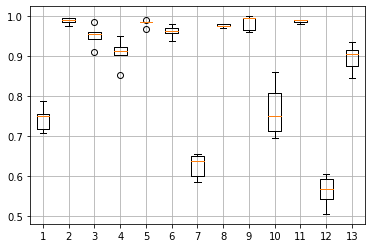

In [12]:
fig = plt.figure()
plt.boxplot(fold_vacc)
plt.grid()
plt.show()